In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Add parent directory to path
sys.path.append(os.path.abspath('..'))

import numpy as np
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import regularizers as reg
from GmGM import GmGM
from utilities import *
from nonparanormal_skeptic import *

from other_algs.EiGLasso import EiGLasso, EiGLasso_cov

# Change colorscheme to be colorblind friendly
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
color_cycler = cycler('color',['k','orange','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

import timeit

In [140]:
# These are the results from ZiLN
ziln_df = pd.read_csv("../data/ll-deep-assortativities.csv", index_col=0)

# Helper Functions

In [139]:
def calculate_assortativity(
    thresholds: np.ndarray,
    preds: dict[str, np.ndarray]
) -> np.ndarray:
    results = np.zeros((len(thresholds), 3, 5))
    threshold_types = ["All", "Per Row", "Per Col"]
    for idx, threshold in enumerate(thresholds):
        if idx % (len(thresholds) // 10) == 0:
            print(f"Threshold {idx} of {len(thresholds)}")
        # Overall #######################

        # Threshold
        preds_all = shrink_sparsities(
            preds,
            {"People": threshold / 565**2, "Species": threshold / 565**2}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_all["Species"] + preds_all["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 0, 0] = g.assortativity(taxmat["Phylum"].cat.codes-1)
        results[idx, 0, 1] = g.assortativity(taxmat["Class"].cat.codes-1)
        results[idx, 0, 2] = g.assortativity(taxmat["Order"].cat.codes-1)
        results[idx, 0, 3] = g.assortativity(taxmat["Family"].cat.codes-1)
        results[idx, 0, 4] = g.assortativity(taxmat["Genus"].cat.codes-1)

        # Per Row #######################

        # Threshold
        preds_row = shrink_per_row(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_row["Species"] + preds_row["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 1, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 1, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 1, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 1, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 1, 4] = g.assortativity(taxmat["Genus"].cat.codes)

        # Per Col #######################

        # Threshold
        preds_col = shrink_per_col(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_col["Species"] + preds_col["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 2, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 2, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 2, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 2, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 2, 4] = g.assortativity(taxmat["Genus"].cat.codes)
    return results

# Load Multimodal Data
This data is from the LifeLines-DEEP dataset, which is not publically available (access can be requested, you will have to reach out to them).

If you cannot get ahold of it, but still want to repeat our results, scroll down further in the notebook!

In [243]:
import muon as mu
import scanpy as sc
from anndata import AnnData
import sklearn.cluster as clust

In [244]:
# Get the taxa
taxmat = pd.read_csv("../data/ll-deep-taxmat.csv", index_col=0)
taxmat.columns = ["Domain", "Phylum", "Class", "Order", "Family", "Genus"]
taxmat = taxmat.fillna("Unknown")
taxmat = taxmat.apply(lambda x: x.astype("category"))

In [245]:
# Read in the mapping linking person ids from metabolomics and metagenomics
# (we actually constructed the latter two datasets such that the nth row matches
# up in all of them - but this still contains gender info)
map_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/Map.csv",
    index_col=0
)
print(map_df.shape)

# Read in the metabolomics data
metabolomics_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/Metabolomics.csv",
    index_col=0
)
print(metabolomics_df.shape)

# Read in the metagenomics data
metagenomics_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/MetagenomicsShotgun.csv",
    index_col=0
)
old_shape = metagenomics_df.shape

# Only keep the species who appear in more than 20% of the people
#keep_idxs = ((counts > 0).sum(axis=0) > 0.2 * counts.shape[0]).values
#counts = counts.loc[:, keep_idxs]
#taxmat = taxmat.loc[keep_idxs, :]
keep_idxs = (metagenomics_df > 0).sum(axis=0) > 0.2 * metagenomics_df.shape[0]
metagenomics_df = metagenomics_df.loc[:, keep_idxs]
taxmat = taxmat.loc[keep_idxs.values, :]

print(old_shape, '->', metagenomics_df.shape)

(1054, 3)
(1054, 1183)
(1054, 3957) -> (1054, 564)


In [246]:
# Load our data into a MuData object
metabol_ann = AnnData(
    X = metabolomics_df.to_numpy()
)
metabol_ann.obs_names = metabolomics_df.index
metabol_ann.var_names = metabolomics_df.columns

metagen_ann = AnnData(
    X = metagenomics_df.to_numpy()
)
metagen_ann.obs_names = metabolomics_df.index # note this is the same as metabolomics
metagen_ann.var_names = metagenomics_df.columns

mudata = mu.MuData({
    "metabolomics": metabol_ann,
    "metagenomics_shotgun": metagen_ann
})

mudata.obs["Gender"] = map_df["Gender"].to_numpy()

# Log transform the data (this modifies in place)
sc.pp.log1p(mudata["metabolomics"])
sc.pp.log1p(mudata["metagenomics_shotgun"])

In [247]:
# Note - for some reason, with scanpy, we only keep 564 species,
# but with manual filtering (see bottom of this notebook), we keep 565
mudata

MuData object with n_obs × n_vars = 1054 × 1747
  obs:	'Gender'
  2 modalities
    metabolomics:	1054 x 1183
      uns:	'log1p'
    metagenomics_shotgun:	1054 x 564
      uns:	'log1p'

In [248]:
shotgun_array = mudata["metagenomics_shotgun"].X
metabol_array = mudata["metabolomics"].X

## Experiment 1: Just Metagenomics

In [249]:
GmGM_results = GmGM(
    {"metagenomics_shotgun": shotgun_array - shotgun_array.mean()},
    {"metagenomics_shotgun": ("People", "Species")},
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False
)

/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:516: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:
/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  err_diff: float = np.abs(prev_err - err)


In [250]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, GmGM_results)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


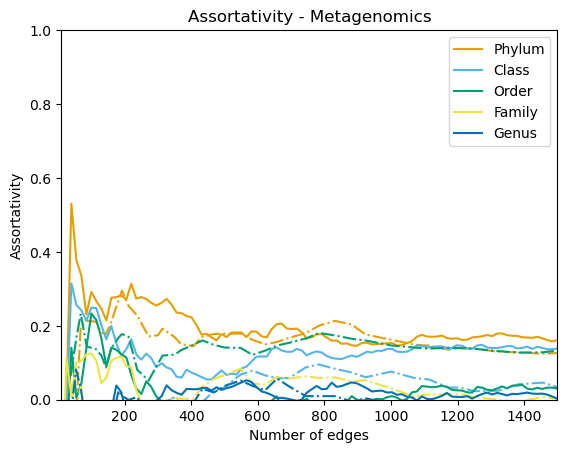

In [251]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics")

fig.savefig("../out_figs/gmgm-metagenomics-assortativity.png", bbox_inches="tight")
fig.savefig("../out_figs/gmgm-metagenomics-assortativity.svg", bbox_inches="tight")

### Experiment 1b: Metagenomics, Nonparanormal

In [266]:
nonpara = nonparanormal_tensor_skeptic(shotgun_array, batchless=True)
nonpara = {
    "People": nonpara[0],
    "Species": nonpara[1]
}
GmGM_results = GmGM(
    {"metagenomics_shotgun": shotgun_array - shotgun_array.mean()},
    {"metagenomics_shotgun": ("People", "Species")},
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False,
    gram_matrices=nonpara
)

In [267]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, GmGM_results)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


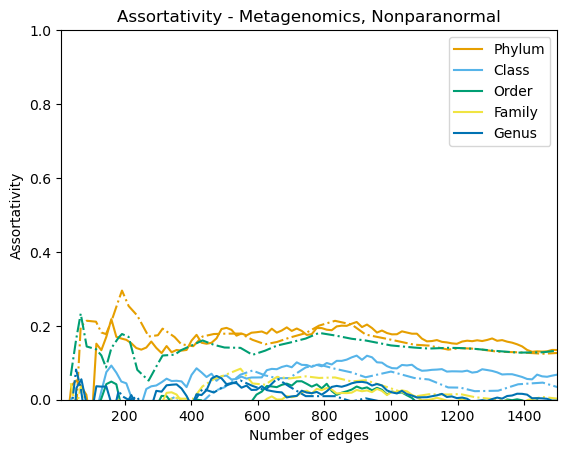

In [268]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics, Nonparanormal")

fig.savefig("../out_figs/gmgm-metagenomics-assortativity-nonpara.png", bbox_inches="tight")
fig.savefig("../out_figs/gmgm-metagenomics-assortativity-nonpara.svg", bbox_inches="tight")

## Experiment 2: Metagenomics + Metabolomics

In [272]:
GmGM_results = GmGM(
    {
        "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        "metabolomics": metabol_array - metabol_array.mean()
    },
    {
        "metagenomics_shotgun": ("People", "Species"),
        "metabolomics": ("People", "Metabolite")
    },
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False
)
GmGM_results = {
    "People": GmGM_results["People"],
    "Species": GmGM_results["Species"]
}

In [273]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, GmGM_results)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


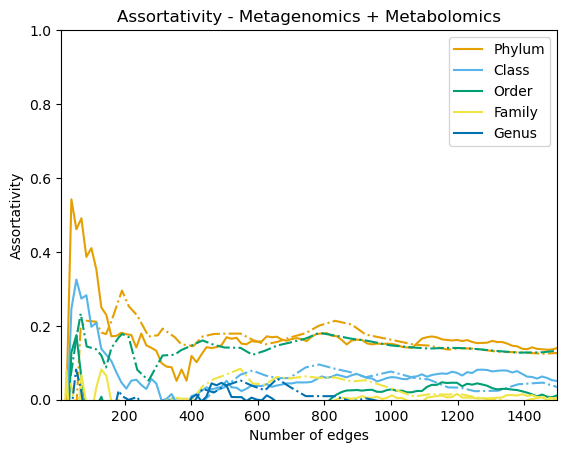

In [274]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics + Metabolomics")

fig.savefig("../out_figs/gmgm-both-assortativity.png", bbox_inches="tight")
fig.savefig("../out_figs/gmgm-both-assortativity.svg", bbox_inches="tight")

### Experiment 2b: Metagenomics + Metabolomics, Nonparanormal

In [269]:
nonpara_1 = nonparanormal_tensor_skeptic(shotgun_array, batchless=True)
nonpara_2 = nonparanormal_tensor_skeptic(metabol_array, batchless=True)
nonpara = {
    "People": nonpara_1[0] + nonpara_2[0],
    "Species": nonpara_1[1],
    "Metabolite": nonpara_2[1]
}
GmGM_results = GmGM(
    {
        "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        "metabolomics": metabol_array - metabol_array.mean()
    },
    {
        "metagenomics_shotgun": ("People", "Species"),
        "metabolomics": ("People", "Metabolite")
    },
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False,
    gram_matrices=nonpara
)
GmGM_results = {
    "People": GmGM_results["People"],
    "Species": GmGM_results["Species"]
}

/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:516: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:
/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  err_diff: float = np.abs(prev_err - err)


In [270]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, GmGM_results)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


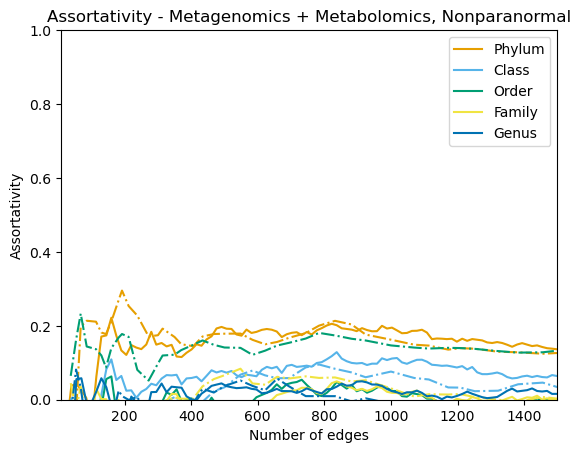

In [271]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics + Metabolomics, Nonparanormal")

fig.savefig("../out_figs/gmgm-both-assortativity-nonpara.png", bbox_inches="tight")
fig.savefig("../out_figs/gmgm-both-assortativity-nonpara.svg", bbox_inches="tight")

## Experiment 3: UMAP Consistency

In [354]:
GmGM_results = GmGM(
    {
        "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        "metabolomics": metabol_array - metabol_array.mean()
    },
    {
        "metagenomics_shotgun": ("People", "Species"),
        "metabolomics": ("People", "Metabolite")
    },
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False
)

/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:516: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:
/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  err_diff: float = np.abs(prev_err - err)


In [375]:
shrunk = shrink_sparsities(GmGM_results, {"People": 0, "Species": 0.07, "Metabolite": 0})["Species"]
shrunk = (shrunk + shrunk.T) / 2
shrunk_graph = ig.Graph.Adjacency(shrunk != 0).as_undirected()

In [376]:
# Create a transposed dataset to make the UMAP easy to plot
transposed_anndata = AnnData(shotgun_array.T)
transposed_anndata.obs_names = mudata["metagenomics_shotgun"].var_names
transposed_anndata.var_names = mudata["metagenomics_shotgun"].obs_names
sc.pp.log1p(transposed_anndata)

In [377]:
# Louvain clustering
louvain = shrunk_graph.community_multilevel().membership
transposed_anndata.obs["louvain"] = [f"Cluster {l}" for l in louvain]

In [378]:
sc.pp.pca(transposed_anndata, n_comps=30)
sc.pp.neighbors(transposed_anndata)
sc.tl.umap(transposed_anndata)

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


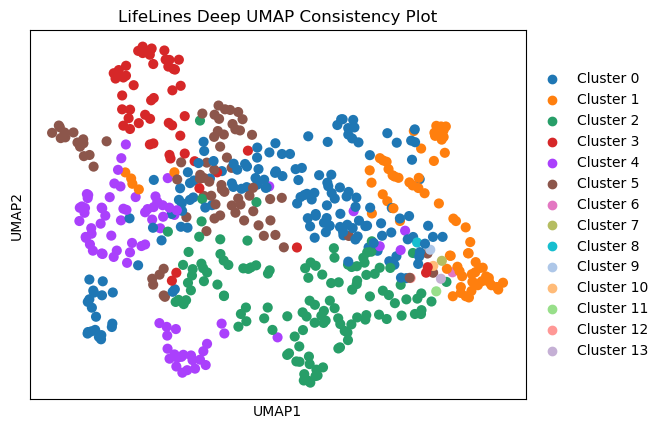

In [402]:
fig, ax = plt.subplots(ncols=1)
sc.pl.umap(
    transposed_anndata,
    color="louvain",
    ax=ax,
    title="LifeLines Deep UMAP Consistency Plot"
)
fig.savefig("../out_figs/lifelines-deep-umap-consistency.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency.svg", bbox_inches="tight")

### Experiment 4: Runtimes

In [387]:
import timeit

In [388]:
# Both
def to_time():
    GmGM_results = GmGM(
        {
            "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
            "metabolomics": metabol_array - metabol_array.mean()
        },
        {
            "metagenomics_shotgun": ("People", "Species"),
            "metabolomics": ("People", "Metabolite")
        },
        tol=1e-8,
        max_iter=1000,
        verbose=False,
        _always_regularize=True,
        _check_overstep_each_iter=False,
        force_posdef=False
    )

np.mean(timeit.repeat(to_time, number=1, repeat=10))

/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:516: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:
/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:514: RuntimeWarning: invalid value encountered in scalar subtract
  err_diff: float = np.abs(prev_err - err)


4.708261437504552

In [389]:
# Metagenomics
def to_time():
    GmGM_results = GmGM(
        {
            "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        },
        {
            "metagenomics_shotgun": ("People", "Species"),
        },
        tol=1e-8,
        max_iter=1000,
        verbose=False,
        _always_regularize=True,
        _check_overstep_each_iter=False,
        force_posdef=False
    )

np.mean(timeit.repeat(to_time, number=1, repeat=10))

1.4804388498974732

In [394]:
def to_time():
    EiGLasso((shotgun_array - shotgun_array.mean())[np.newaxis], beta_1=0, beta_2=0)

np.mean(timeit.repeat(to_time, number=1, repeat=1))

3787.477204708004

## Experiment 5: Priors

In [413]:
# Crate prior connecting species in the same phylum
base = np.array(taxmat["Phylum"].cat.codes)[np.newaxis]
prior = (base == base.T).astype(float)
np.fill_diagonal(prior, 1.1)

In [416]:
GmGM_results_with_prior = GmGM(
    {
        "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        "metabolomics": metabol_array - metabol_array.mean()
    },
    {
        "metagenomics_shotgun": ("People", "Species"),
        "metabolomics": ("People", "Metabolite")
    },
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False,
    prior={"Species": prior},
    prior_type={"Species": "wishart"}
)
GmGM_results_with_prior = {
    "People": GmGM_results_with_prior["People"],
    "Species": GmGM_results_with_prior["Species"]
}

/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:542: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:
/Users/baileyandrew/Desktop/VSCode.nosync/GmGM-Polyglot/python_frontend/GmGM.py:540: RuntimeWarning: invalid value encountered in scalar subtract
  err_diff: float = np.abs(prev_err - err)


In [417]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, GmGM_results_with_prior)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


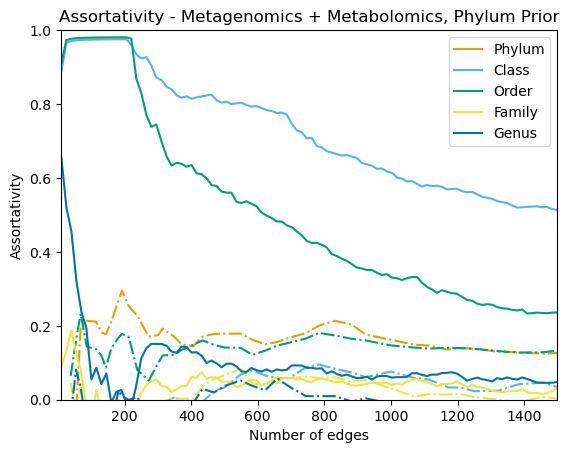

In [418]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics + Metabolomics, Phylum Prior")

fig.savefig("../out_figs/gmgm-both-assortativity-prior.png", bbox_inches="tight")
fig.savefig("../out_figs/gmgm-both-assortativity-prior.svg", bbox_inches="tight")

# Load the ZiLN Data
This data is publically available, in ZiLN's repository, so if you do not have access to the full dataset then you can use this!

In [229]:
# Load data from ../data/ll-deep-counts.csv
counts = pd.read_csv("../data/ll-deep-counts.csv", index_col=0)

# Load labels from ../data/ll-deep-taxmat.csv
taxmat = pd.read_csv("../data/ll-deep-taxmat.csv", index_col=0)

# Replace NaN with "Unknown"
taxmat = taxmat.fillna("Unknown")

In [230]:
# V2 -> Domain
# V3 -> Phylum
# V4 -> Class
# V5 -> Order
# V6 -> Family
# V7 -> Genus
# Rename these columns in taxmat
taxmat.columns = ["Domain", "Phylum", "Class", "Order", "Family", "Genus"]

In [231]:
# Convert columns to categorical
taxmat = taxmat.apply(lambda x: x.astype("category"))

In [232]:
# Only keep the species who appear in more than 20% of the people
keep_idxs = ((counts > 0).sum(axis=0) > 0.2 * counts.shape[0]).values
counts = counts.loc[:, keep_idxs]
taxmat = taxmat.loc[keep_idxs, :]

In [233]:
log_counts = np.log(counts + 1)
log_counts = log_counts.values

In [234]:
def calculate_assortativity(
    thresholds: np.ndarray,
    preds: dict[str, np.ndarray]
) -> np.ndarray:
    results = np.zeros((len(thresholds), 3, 5))
    threshold_types = ["All", "Per Row", "Per Col"]
    for idx, threshold in enumerate(thresholds):
        if idx % (len(thresholds) // 10) == 0:
            print(f"Threshold {idx} of {len(thresholds)}")
        # Overall #######################

        # Threshold
        preds_all = shrink_sparsities(
            preds,
            {"People": threshold / 565**2, "Species": threshold / 565**2}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_all["Species"] + preds_all["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 0, 0] = g.assortativity(taxmat["Phylum"].cat.codes-1)
        results[idx, 0, 1] = g.assortativity(taxmat["Class"].cat.codes-1)
        results[idx, 0, 2] = g.assortativity(taxmat["Order"].cat.codes-1)
        results[idx, 0, 3] = g.assortativity(taxmat["Family"].cat.codes-1)
        results[idx, 0, 4] = g.assortativity(taxmat["Genus"].cat.codes-1)

        # Per Row #######################

        # Threshold
        preds_row = shrink_per_row(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_row["Species"] + preds_row["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 1, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 1, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 1, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 1, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 1, 4] = g.assortativity(taxmat["Genus"].cat.codes)

        # Per Col #######################

        # Threshold
        preds_col = shrink_per_col(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_col["Species"] + preds_col["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 2, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 2, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 2, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 2, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 2, 4] = g.assortativity(taxmat["Genus"].cat.codes)
    return results

In [235]:
# These are the results from ZiLN
ziln_df = pd.read_csv("../data/ll-deep-assortativities.csv", index_col=0)

## Experiment 1: Just Metagenomics

In [236]:
# Run GmGM on it
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("People", "Species")},
    batch_axes=set({}),
    regularizer=None,
    tol=1e-8,#1e-3,
    _always_regularize=True,#True,
    _check_overstep_each_iter=False,#True,
    verbose=True,
    verbose_every=1000,
    force_posdef=False,#True
)
np.fill_diagonal(preds["People"], 0)
np.fill_diagonal(preds["Species"], 0)

@0: -585263.7556015996 (-585269.6875 + 5.931898400466082 + 0) ∆inf
Did not converge!


In [237]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, preds)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


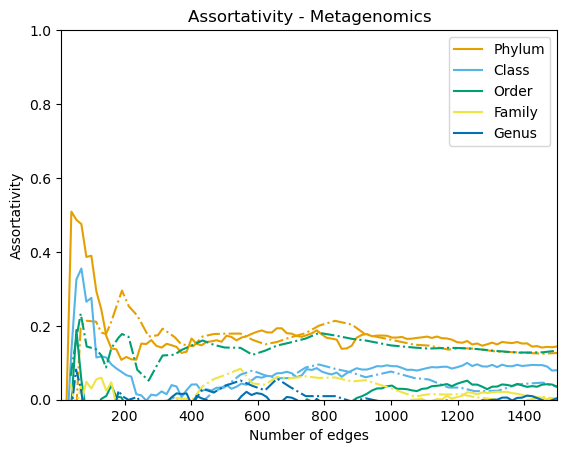

In [238]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics")

fig.savefig("../out_figs/ziln-metagenomics-assortativity.png", bbox_inches="tight")
fig.savefig("../out_figs/ziln-metagenomics-assortativity.svg", bbox_inches="tight")

## Experiment 2: Nonparanormal Metagenomics

In [39]:
# Run GmGM on it
nonpara = nonparanormal_tensor_skeptic(log_counts, batchless=True)
nonpara = {
    "People": nonpara[0],
    "Species": nonpara[1]
}
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("People", "Species")},
    batch_axes=set({}),
    regularizer=None,
    tol=1e-8,#1e-3,
    _always_regularize=True,#True,
    _check_overstep_each_iter=False,#True,
    verbose=True,
    verbose_every=1000,
    force_posdef=False,#True
    gram_matrices=nonpara
)
np.fill_diagonal(preds["People"], 0)
np.fill_diagonal(preds["Species"], 0)

@0: -584495.8957299466 (-584503.4375 + 7.541770053390161 + 0) ∆inf
Did not converge!


In [40]:
thresholds = np.linspace(10, 1500, 100).astype(int)
results = calculate_assortativity(thresholds, preds)

Threshold 0 of 100
Threshold 10 of 100
Threshold 20 of 100
Threshold 30 of 100
Threshold 40 of 100
Threshold 50 of 100
Threshold 60 of 100
Threshold 70 of 100
Threshold 80 of 100
Threshold 90 of 100


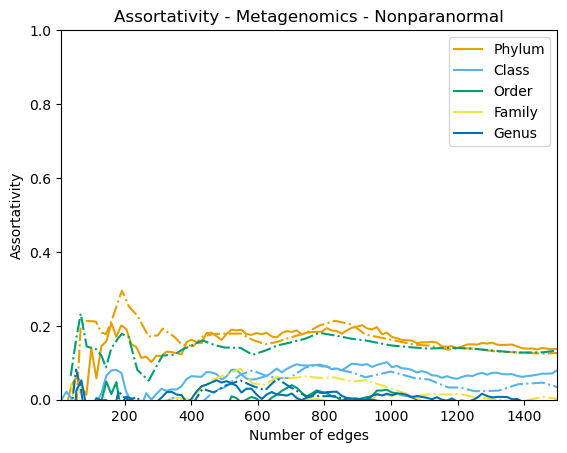

In [41]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(len(taxmat.columns)-1):
    ax.plot(
        thresholds,
        results[:, 0, i],
        label=f"{taxmat.columns[i+1]}",
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-'
    )
    ax.plot(
        ziln_df['num_edges'],
        ziln_df[taxmat.columns[i+1]],
        color=["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"][i],
        linestyle='-.'
    )

ax.set_xlabel("Number of edges")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(thresholds.min(), thresholds.max())
ax.set_ylim(0, 1)

ax.set_title("Assortativity - Metagenomics - Nonparanormal")

fig.savefig("../out_figs/ziln-metagenomics-assortativity-nonpara.png", bbox_inches="tight")
fig.savefig("../out_figs/ziln-metagenomics-assortativity-nonpara.svg", bbox_inches="tight")